# Normalizing Flow

## 1. Training Stage

In [12]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)
    
num_categories = {}
for column in hts_df.columns:
    num_unique = hts_df[column].nunique()
    num_categories[column] = num_unique
    print(f"Column '{column}' has {num_unique} unique categories.")

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.


In [3]:
def dequantize_data(data):
    data_continuous = data.copy().astype(float)
    for column in data_continuous.columns:
        data_continuous[column] += np.random.uniform(0, 1, size=data_continuous.shape[0])
    return data_continuous

data_continuous = dequantize_data(hts_df)
data_tensor = torch.tensor(data_continuous.values, dtype=torch.float32).to(device)

In [4]:
class AffineCoupling(nn.Module):
    """
    Affine Coupling Layer as introduced in RealNVP.
    Splits the input into two parts and applies an affine transformation to one part conditioned on the other.
    """
    def __init__(self, input_dim, hidden_dim, mask):
        super(AffineCoupling, self).__init__()
        self.mask = mask
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # To keep scale bounded
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian
    
    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det_jacobian = -torch.sum(s, dim=1)
        return x, log_det_jacobian

class NormalizingFlow(nn.Module):
    """
    A simple Normalizing Flow composed of multiple affine coupling layers and permutations.
    """
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList()
        mask = self.create_mask(input_dim, even=True)
        for i in range(num_layers):
            self.layers.append(AffineCoupling(input_dim, hidden_dim, mask))
            # Alternate the mask for the next layer
            mask = 1 - mask
        # Base distribution parameters (mean and log_std for a standard normal)
        self.base_mean = torch.zeros(input_dim).to(device)
        self.base_log_std = torch.zeros(input_dim).to(device)
    
    def create_mask(self, input_dim, even=True):
        """
        Create a binary mask for coupling layers.
        """
        mask = torch.zeros(input_dim)
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask.to(device)
    
    def forward(self, x):
        """
        Forward pass through the flow: transform x to z and compute log_prob.
        """
        log_det_jacobian = torch.zeros(x.size(0)).to(device)
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        # Compute log_prob under base distribution
        log_prob_z = self.base_log_prob(x)
        log_prob = log_prob_z + log_det_jacobian
        return log_prob
    
    def inverse(self, z):
        """
        Inverse pass through the flow: transform z to x.
        """
        for layer in reversed(self.layers):
            z, _ = layer.inverse(z)
        return z
    
    def base_log_prob(self, z):
        """
        Compute log probability under the base distribution (standard normal).
        """
        log_std = self.base_log_std
        mean = self.base_mean
        return -0.5 * (((z - mean) / torch.exp(log_std)) ** 2 + 2 * log_std + np.log(2 * np.pi)).sum(1)


In [5]:
hidden_dim = 128
num_layers = 6  # Number of affine coupling layers

input_dim = data_tensor.shape[1]
flow_model = NormalizingFlow(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)

In [6]:
learning_rate=1e-3
batch_size=512 
epochs=20

optimizer = optim.Adam(flow_model.parameters(), lr=learning_rate)

dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

flow_model.train()
for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        log_prob = flow_model(x)
        loss = -torch.mean(log_prob)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    epoch_loss /= len(dataloader.dataset)
    if epoch % 2 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/20], Loss: 4.9380
Epoch [2/20], Loss: 4.1768
Epoch [4/20], Loss: 3.9964
Epoch [6/20], Loss: 3.9183
Epoch [8/20], Loss: 3.8685
Epoch [10/20], Loss: 3.8565
Epoch [12/20], Loss: 3.8076
Epoch [14/20], Loss: 3.7830
Epoch [16/20], Loss: 3.7688
Epoch [18/20], Loss: 3.7565
Epoch [20/20], Loss: 3.7413


## 2. Testing Stage

In [7]:
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples=3000

flow_model.eval()

with torch.no_grad():
    z = torch.randn(num_samples, len(columns)).to(device)
    samples = flow_model.inverse(z).cpu().numpy()
    
generated_categories = pd.DataFrame(samples, columns=columns)
for column in columns:
    max_cat = num_categories[column] - 1
    generated_categories[column] = np.floor(generated_categories[column]).astype(int)
    generated_categories[column] = np.clip(generated_categories[column], 0, max_cat)

<ipython-input-14-3da845af3a87>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=12)


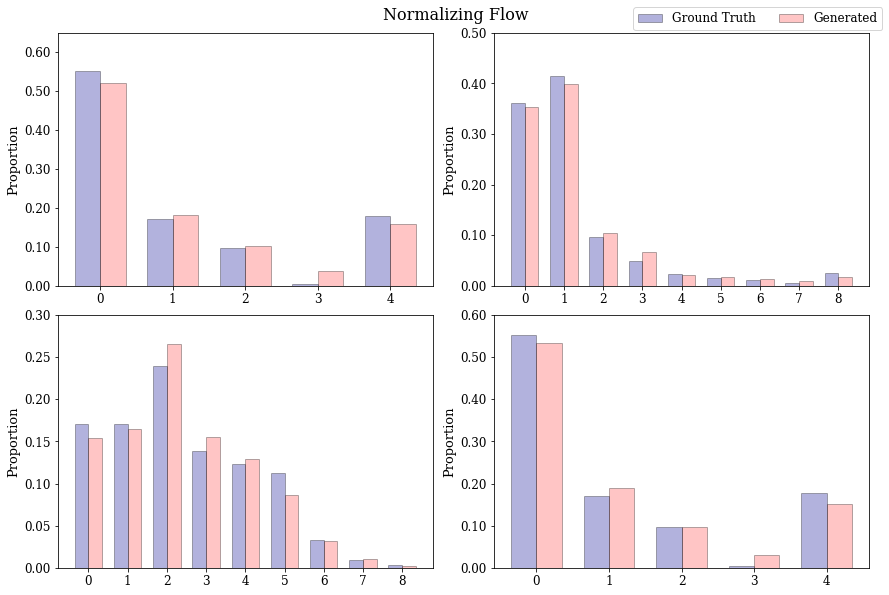

In [14]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

formatter = FormatStrFormatter('%.2f')

fig.tight_layout(h_pad=1, w_pad=3)

ylim_list = [0.65, 0.5, 0.3, 0.6]
bar_width = 0.35
offset = bar_width / 2 

for column, ylim, ax in zip(columns, ylim_list, axs.flatten()):
    
    # Ground truth
    unique_hts, counts_hts = np.unique(hts_df[column], return_counts=True)
    ax.set_ylim([0, ylim])
    positions_hts = np.arange(len(unique_hts))
    ax.bar(positions_hts - offset, counts_hts / counts_hts.sum(), 
           width=bar_width, color='#00008F', edgecolor='black', alpha=0.3, label='Ground Truth')
    
    # Generated data
    unique_gen, counts_gen = np.unique(generated_categories[column], return_counts=True)
    positions_gen = np.arange(len(unique_gen))
    ax.bar(positions_gen + offset, counts_gen / counts_gen.sum(), 
           width=bar_width, color='#FF4040', edgecolor='black', alpha=0.3, label='Generated')
    
    ax.set_xticks([int(x) for x in unique_hts])
    ax.set_xticklabels([int(x) for x in unique_hts], fontsize=12) 
    
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=12)
    
    ax.set_ylabel('Proportion', fontsize=13)

fig.suptitle('Normalizing Flow', fontsize=16, y=1.02)

fig.legend(['Ground Truth', 'Generated'], loc='upper right', ncol=2, fontsize=12, 
           bbox_to_anchor=(1, 1.03), bbox_transform=fig.transFigure)

plt.savefig(f'nf_discrete.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()